In [1]:
import sys
import os
from pathlib import Path

import sys
import os
from pathlib import Path
parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)
sys.path.append("../models")
processed_series_path = Path(parent_dir) / 'processed_series'
import copy
from scipy.special import erf
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import pickle

print(sys.path)
from ICL import MultiResolutionPDF

['/home/admin-quad/Toni/LLMICL_inPCA/inPCA', '/home/admin-quad/anaconda3/envs/LLM/lib/python311.zip', '/home/admin-quad/anaconda3/envs/LLM/lib/python3.11', '/home/admin-quad/anaconda3/envs/LLM/lib/python3.11/lib-dynload', '', '/home/admin-quad/anaconda3/envs/LLM/lib/python3.11/site-packages', '/home/admin-quad/LLM/llama', '/home/admin-quad/Toni/LLMICL_inPCA', '../models']


In [2]:
all_files = sorted([path for path in processed_series_path.iterdir()], key=lambda x: x.name)
for index, file in enumerate(all_files):
    print(f"[{index}]: {file.name}")

[0]: uncorrelated_gaussian_centered_sigma_0.1_0.pkl
[1]: uncorrelated_gaussian_centered_sigma_0.1_1.pkl
[2]: uncorrelated_gaussian_centered_sigma_0.3_0.pkl
[3]: uncorrelated_gaussian_centered_sigma_0.3_1.pkl
[4]: uncorrelated_gaussian_centered_sigma_0.5_0.pkl
[5]: uncorrelated_gaussian_centered_sigma_0.5_1.pkl
[6]: uncorrelated_gaussian_centered_sigma_0.8_0.pkl
[7]: uncorrelated_gaussian_centered_sigma_0.8_1.pkl
[8]: uncorrelated_uniform_centered_sigma_0.1_0.pkl
[9]: uncorrelated_uniform_centered_sigma_0.1_1.pkl
[10]: uncorrelated_uniform_centered_sigma_0.3_0.pkl
[11]: uncorrelated_uniform_centered_sigma_0.3_1.pkl
[12]: uncorrelated_uniform_centered_sigma_0.5_0.pkl
[13]: uncorrelated_uniform_centered_sigma_0.5_1.pkl
[14]: uncorrelated_uniform_centered_sigma_0.8_0.pkl
[15]: uncorrelated_uniform_centered_sigma_0.8_1.pkl


In [12]:
alpha = 1

# uncorrelated gaussian, heterogeneous bin
# file = all_files[127] 
# file = all_files[128] 

# uncorrelated gaussian, uniform bin
# file = all_files[129] 
# file = all_files[130]  
# file = all_files[131] 
# file = all_files[132] 
# file = all_files[133] 

# file = all_files[134] 
# file = all_files[135] 
# file = all_files[136] 
# file = all_files[137] 

# narrow gaussian
# uncorrelated_gaussian_centered_sigma
# sigma 0.1
file = all_files[139]
file = all_files[140]
file = all_files[141]

# sigma 0.3
file = all_files[144]
file = all_files[145]

# sigma 0.7
file = all_files[158]

# uniform distributions
file = all_files[168]
file = all_files[183]

# BM motion
# file = all_files[4] 

processed_dict = pickle.load(file.open('rb'))
full_series = processed_dict['full_series']
rescaled_true_mean_arr = processed_dict['rescaled_true_mean_arr']
rescaled_true_sigma_arr = processed_dict['rescaled_true_sigma_arr']
llama_size = processed_dict['llama_size']
mode = processed_dict['mode']
refine_depth = processed_dict['refine_depth']
random_seed = processed_dict['random_seed']
PDF_list = processed_dict['PDF_list']
time_series = processed_dict['time_series']
prec = processed_dict['prec']
print(f"seed: {processed_dict['random_seed']}")
print(f"mode: {mode}")
print(f"refine_depth: {refine_depth}")
print(f"prec: {prec}")
print(f"name: {file.stem}")

seed: 2
mode: all
refine_depth: 1
prec: 2
name: uncorrelated_uniform_centered_sigma_0.7_0


In [13]:
rescaled_true_sigma_arr[1]

2.4999999999999996

In [14]:
### tune temperature and sort by bin center
for PDF in PDF_list:
    PDF.sort_by_center()
    if alpha != 1:
        PDF.rescale_temperature(alpha)

In [15]:
### average over steps
avg_interval = 8
PDF_list_averaged = []
common_bin_center_arr = PDF_list[0].bin_center_arr
common_bin_width_arr = PDF_list[0].bin_width_arr
for i in range(len(PDF_list)-avg_interval):
    avg_bin_height_arr = np.average([PDF_list[i+x].bin_height_arr for x in range(avg_interval)], axis = 0)
    avg_PDF = MultiResolutionPDF()
    avg_PDF.add_bin(common_bin_center_arr, common_bin_width_arr, avg_bin_height_arr)
    PDF_list_averaged += [avg_PDF]
    
PDF_list = PDF_list_averaged    

In [16]:
### Calculate geodesic 
analytic_truth = 1 # use last time step as truth otherwise
geodesic_steps = 20

PDF_geodesic_list = copy.deepcopy(PDF_list[:geodesic_steps])
PDF_ignorance = copy.deepcopy(PDF_list[0])
def cdf(x):
    return np.clip(x / 10, 0, 1)
PDF_ignorance.discretize(cdf, mode = "cdf")

PDF_true = copy.deepcopy(PDF_list[-1])
if analytic_truth:
    def cdf(x):
        return 0.5 * (1 + erf((x - rescaled_true_mean_arr[-1]) / (rescaled_true_sigma_arr[-1] * np.sqrt(2))))
    PDF_true.discretize(cdf, mode = "cdf")

PDF_ignorance_sqrt = np.sqrt(PDF_ignorance.bin_height_arr)
PDF_true_sqrt = np.sqrt(PDF_true.bin_height_arr)
dG = np.arccos(1-PDF_true.Hel_dist(PDF_ignorance)**2/2)
denom = np.sin(dG)
for i in range(geodesic_steps):
    a = i/geodesic_steps
    u_coef = np.sin((1-a)*dG)/denom
    v_coef = np.sin(a*dG)/denom
    PDF_geodesic_list[i].bin_height_arr = np.square(u_coef * PDF_ignorance_sqrt + v_coef * PDF_true_sqrt)

In [17]:
%matplotlib inline 
from ipywidgets import interact

def plotter(idx):
    fig=plt.figure(figsize = (5,1))
    ax = fig.add_subplot(111)
    PDF_geodesic_list[idx].plot(ax=ax, statistic = False)

interact(plotter, idx=(0, geodesic_steps-1, 1))


interactive(children=(IntSlider(value=9, description='idx', max=19), Output()), _dom_classes=('widget-interact…

<function __main__.plotter(idx)>

In [18]:
PDF_true_list = copy.deepcopy(PDF_list)
for PDF_true, true_mean, true_sigma in zip(PDF_true_list, rescaled_true_mean_arr, rescaled_true_sigma_arr):
    def cdf(x):
        return 0.5 * (1 + erf((x - true_mean) / (true_sigma * np.sqrt(2))))
    PDF_true.discretize(cdf, mode = "cdf")




interactive(children=(IntSlider(value=1, description='comma_idx', max=399, min=1), Output()), _dom_classes=('w…

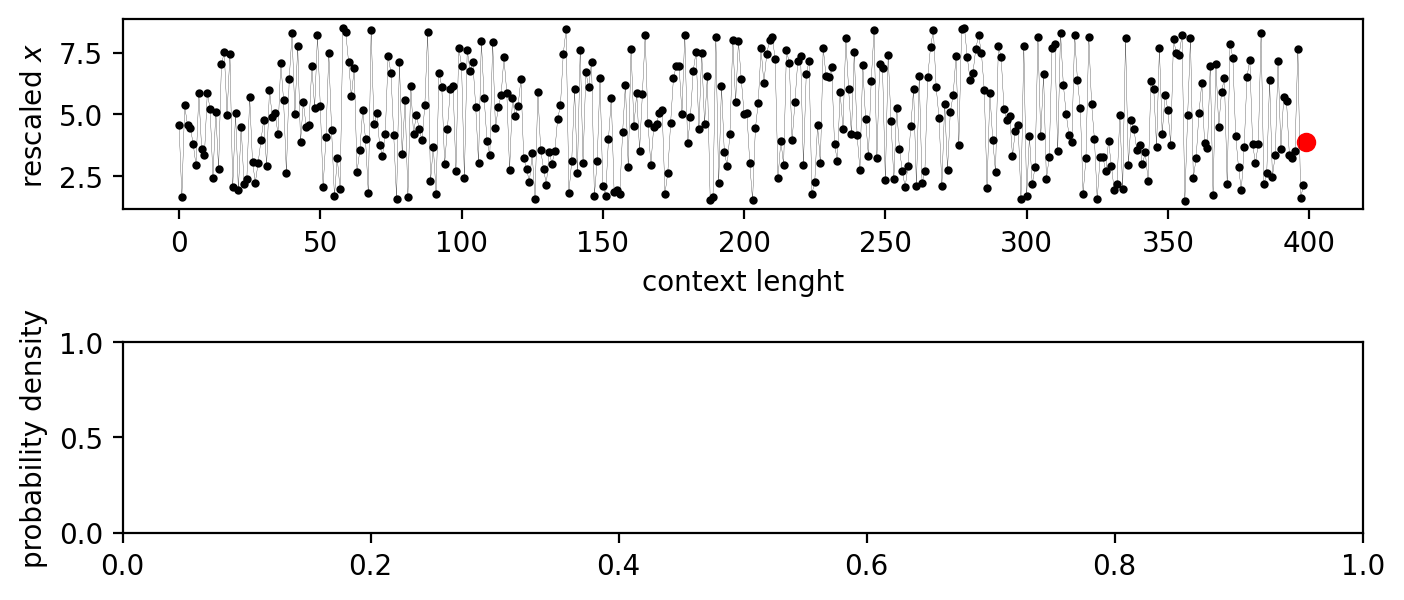

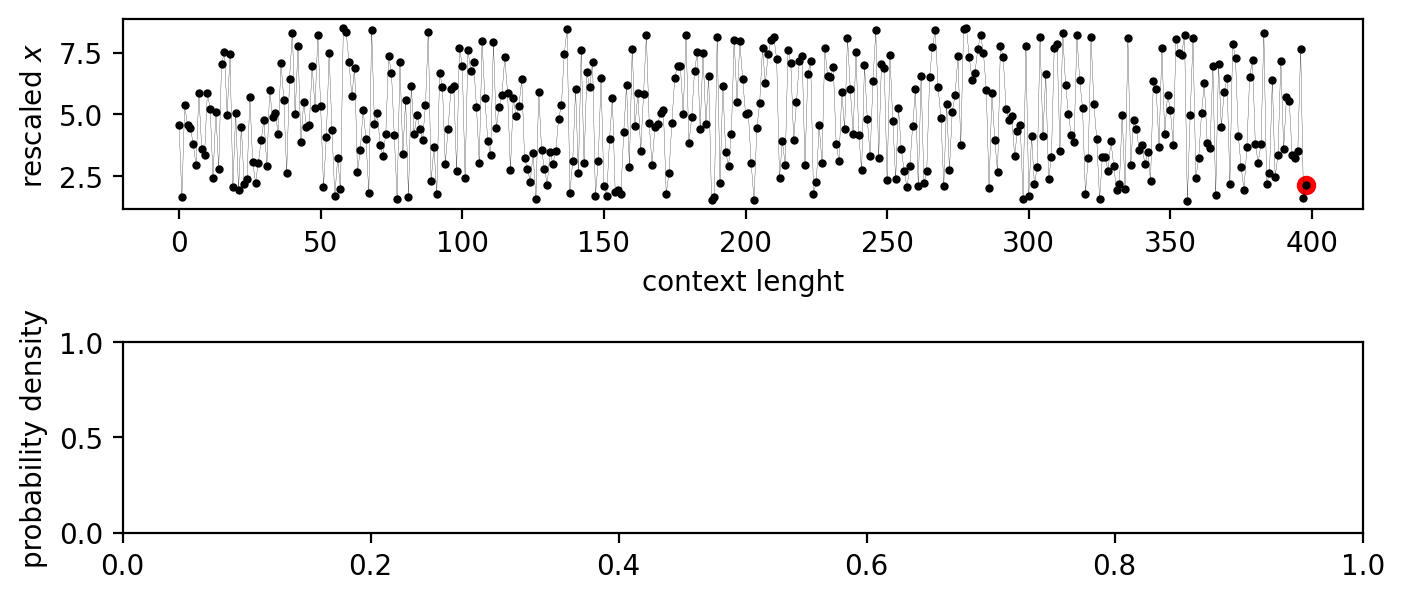

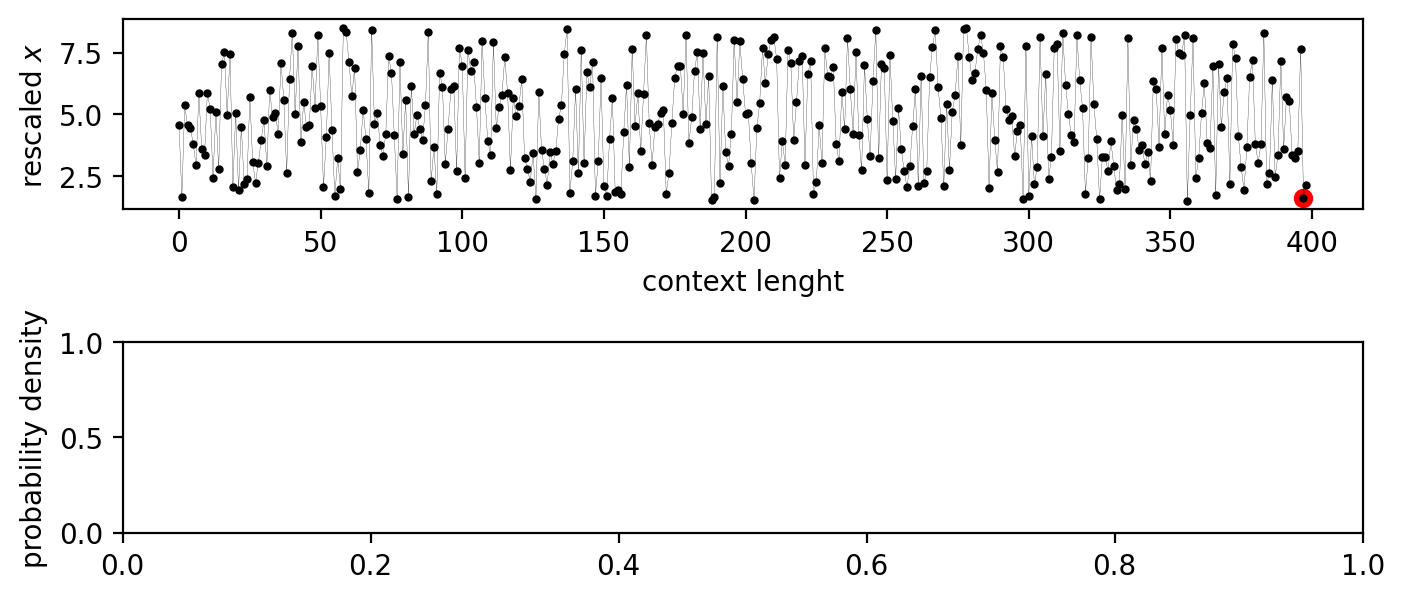

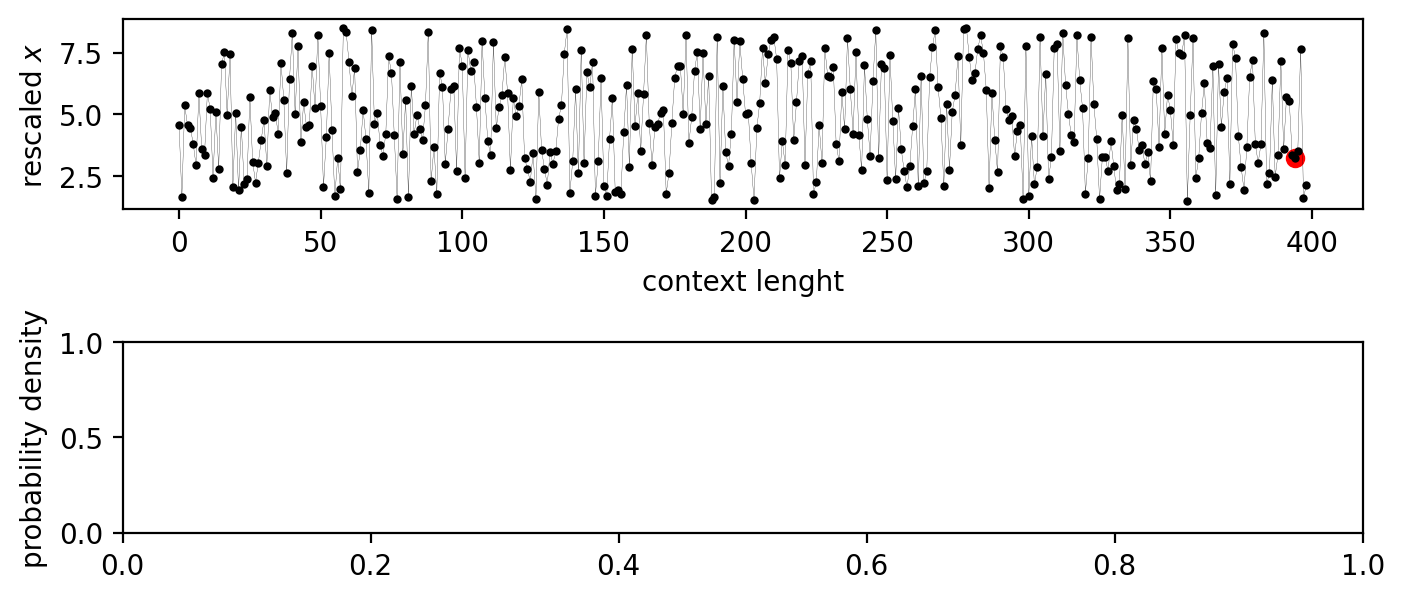

In [19]:
from ipywidgets import interact
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline 
save_path = f"../figures/BM_example_temp{alpha}.png"
### Load multiple digits to MultiResolutionPDF
comma_locations = np.sort(np.where(np.array(list(full_series)) == ',')[0])
time_series_rescaled = (time_series-time_series.min()) / (time_series.max()-time_series.min()) * (8.5-1.5) + 1.5

plot1_log_scale = 0
log_scale = 0
truth_PDF = 0
# final_state = 709
final_state = None

### Plot distribution before ith comma
def digiprob_plotter(comma_idx=1):
    if comma_idx == 0:
        start_idx = 0
    else:
        start_idx = comma_locations[comma_idx-1]+1
    if truth_PDF:
        fig, axs = plt.subplots(3, 1, figsize=(8, 5), dpi = 200)
    else:
        fig, axs = plt.subplots(2, 1, figsize=(8, 10/3), dpi = 200)
    # Adjust the horizontal space between subplots
    plt.subplots_adjust(hspace=0.7)
    # Plot the full array with a marker on the selected value
    if final_state is not None:
        time_series_plot = time_series_rescaled[:final_state+1]
        axs[0].set_xlim(-10, final_state+10)
    else:
        time_series_plot = time_series_rescaled
    axs[0].plot(time_series_plot[:-1], marker='o', color='black', markersize=2, lw = '0.1', label = "observation")
    axs[0].scatter(comma_idx, time_series_plot[comma_idx], color='r', marker='o', label = "prediction")
    axs[0].set_xlabel('context lenght')
    axs[0].set_ylabel(r'rescaled $x$')
    
    if plot1_log_scale:
        axs[0].set_yscale('log')
        
    # Plot softmax distributions for each digit
    axs[1].set_ylabel("probability density")
    # axs[1].set_title(full_series[start_idx-30:start_idx] + "?")      
    PDF_list[comma_idx].compute_stats()
    PDF_list[comma_idx].plot(ax = axs[1], log_scale=log_scale, statistic = False)
    if truth_PDF:
        PDF_true_list[comma_idx].plot(ax = axs[2], log_scale=log_scale, statistic = False)
        axs[2].set_title('discretized truth')
        axs[2].set_xlabel("Digit")
    
    # characterizing ground truth distribution
    true_mean = rescaled_true_mean_arr[comma_idx]
    true_sigma = rescaled_true_sigma_arr[comma_idx]
    if true_sigma == 0:
        axs[1].vlines(true_mean, 0, np.max(PDF_list[comma_idx].bin_height_arr), color='r', label='Truth', lw = 3, alpha = 0.7)
    else:
        x_values = np.linspace(0, 10, 300)
        gaussian = norm.pdf(x_values, true_mean, true_sigma)
        axs[1].plot(x_values, gaussian, color = 'r', label = 'Truth', lw = 3, alpha = 0.7)
        # axs[1].vlines(true_mean, 0, np.max(gaussian), color = 'r')
    # axs[1].set_ylim(np.min(pdf.bin_height_arr), np.max(gaussian)*1.7)
    axs[1].set_xlabel(r'rescaled $x$')
    axs[1].bar([0], [0], color='dodgerblue', label='LLM Prediction')
    axs[1].set_xlim(0,10)
    # axs[1].set_ylim(0,5)
    axs[0].legend()
    axs[1].legend()
    if log_scale:
        axs[1].set_ylim(0.00005,10)
        if truth_PDF:
            axs[2].set_ylim(0.0005,10)
    if final_state is not None: 
        plt.tight_layout()
        plt.savefig(save_path)

# Adjust the range of the slider to match the number of commas in the series
num_commas = full_series.count(',')
if final_state is not None: 
    interact(digiprob_plotter, comma_idx=final_state)
else:
    interact(digiprob_plotter, comma_idx=(1, num_commas-1, 1))

### Compute pair-wise distance

In [26]:
import numpy as np
PDF_slice = slice(0,120)
# PDF_slice = slice(200,500)
# PDF_slice = slice(-101, -1)

PDF_emb_list = PDF_list[PDF_slice] + PDF_geodesic_list
# Initialize the matrix D with zeros. The size of the matrix is determined by the length of PDF_list.
num_PDFs = len(PDF_emb_list)
D_Hel = np.zeros((num_PDFs, num_PDFs))
# Populate the upper triangle of the matrix with the BT distances.
for i in range(num_PDFs):
    for j in range(i+1, num_PDFs):  # Start from i+1 to avoid computing the distance of an object with itself
        D_Hel[i, j] = PDF_emb_list[j].Hel_dist(PDF_emb_list[i])

In [27]:
len(PDF_emb_list)

140

In [28]:
# Copy the upper triangle to the lower triangle to make the matrix symmetric.
# truncate
D_BT = -np.log(1-np.square(D_Hel)/2)
D_Hel = D_Hel + D_Hel.T
D_BT = D_BT + D_BT.T

P = np.eye(num_PDFs) - np.ones(num_PDFs)/num_PDFs
XXT_Hel = -P @ np.square(D_Hel) @ P
XXT_BT = -P @ D_BT @ P

### Hellinger Embedding

array([8.76116406, 0.70150063, 0.42299093])

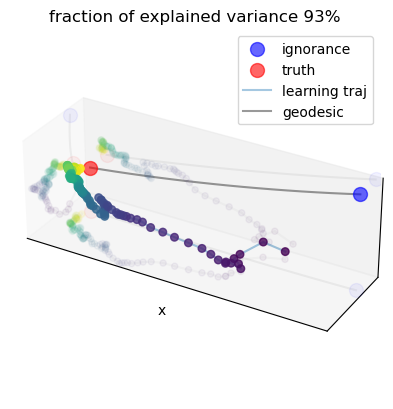

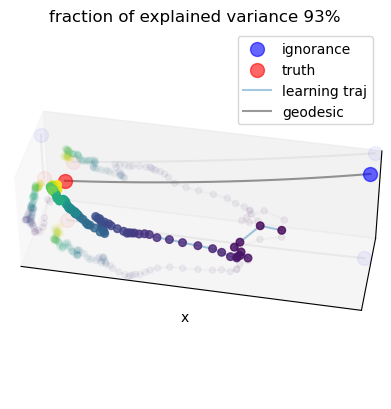

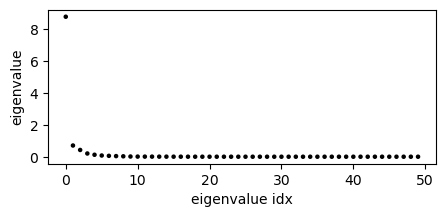

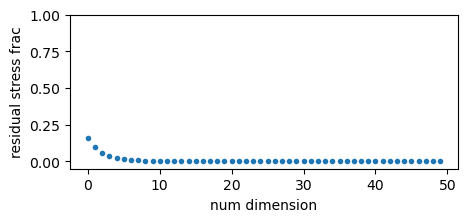

In [29]:
sigma, U = np.linalg.eigh(XXT_Hel)
# Reorder sigma and U based on the absolute value of sigma in decreasing order
idx = np.argsort(np.abs(sigma))[::-1]
sigma = sigma[idx]
U = U[:, idx]
U_rescaled = U * np.sqrt(np.abs(sigma))
# U_rescaled = U * sigma

%matplotlib inline 
# Plot with color based on the sign of sigma
spectrum_cutoff = 50
colors = ['black' if value > 0 else 'red' for value in sigma[:spectrum_cutoff]]
plt.figure(figsize=(5,2), dpi=100)
plt.scatter(range(spectrum_cutoff), np.abs(sigma[:spectrum_cutoff]), c=colors, s = 5)
plt.xlabel('eigenvalue idx')
plt.ylabel('eigenvalue')
# plt.yscale("log")

total_var = np.sum(np.abs(sigma))
explained_var = np.cumsum(np.abs(sigma))
plt.figure(figsize=(5,2), dpi=100)
plt.plot(1-explained_var[:50]/total_var, marker = '.', lw =0)
# plt.ylim(0,1.1)
# plt.yscale('log')
plt.xlabel('num dimension')
plt.ylabel('residual stress frac')
plt.ylim(-0.05,1)
sigma[:3]

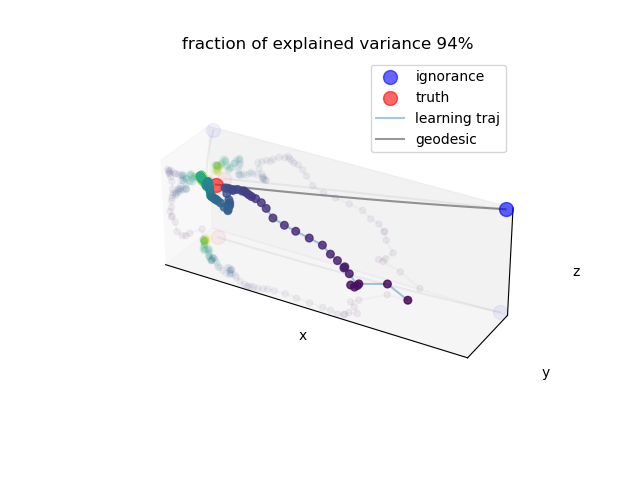

In [34]:
time_cutoff = 120
interval = 1

interactive = 1
shadows = 1
shadow_alpha = 0.05
if interactive:
    #interactive 3D plot
    %matplotlib widget 
    fig = plt.figure(dpi = 100)
else:    
# static 3D plot
    %matplotlib inline 
    fig = plt.figure(dpi = 100, figsize=(8,8))
    
save_path = f"../figures/{file.stem}_Hellinger_3D.png"
ax = fig.add_subplot(111, projection='3d')

# invert x axis
# U_rescaled[:,0] = -U_rescaled[:,0]
ax.scatter3D(U_rescaled[:time_cutoff:interval,0], U_rescaled[:time_cutoff:interval,1], U_rescaled[:time_cutoff:interval,2], c=range(int(time_cutoff/interval)), s = 30, alpha = 0.8)
ax.scatter3D(U_rescaled[-geodesic_steps,0], U_rescaled[-geodesic_steps,1], U_rescaled[-geodesic_steps,2], c='blue', s = 100, label ="ignorance", alpha = 0.6)
ax.scatter3D(U_rescaled[-1,0], U_rescaled[-1,1], U_rescaled[-1,2], c='red', s = 100, label ="truth", alpha = 0.6)
ax.plot(U_rescaled[:time_cutoff:interval,0], U_rescaled[:time_cutoff:interval,1],U_rescaled[:time_cutoff:interval,2], alpha = 0.4, label ="learning traj")
ax.plot(U_rescaled[-geodesic_steps:,0], U_rescaled[-geodesic_steps:,1],U_rescaled[-geodesic_steps:,2], c='black', alpha = 0.4, label ="geodesic")
ax.legend()


x_min, x_max = U_rescaled[:,0].min(), U_rescaled[:,0].max()
y_min, y_max = U_rescaled[:,1].min(), U_rescaled[:,1].max()
z_min, z_max = U_rescaled[:,2].min(), U_rescaled[:,2].max()
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_zlim(z_min, z_max)

if shadows:
    # 2D projections
    for zdir, zs, idx_tuple in zip(['x','y','z'],[x_min, y_max, z_min],[(1,2),(0,2),(0,1)]):
        ax.plot(U_rescaled[:time_cutoff:interval,idx_tuple[0]], U_rescaled[:time_cutoff:interval,idx_tuple[1]], zdir=zdir, c = 'gray', alpha = shadow_alpha, zs=zs)
        ax.scatter(U_rescaled[:time_cutoff:interval,idx_tuple[0]], U_rescaled[:time_cutoff:interval,idx_tuple[1]], zdir=zdir, c = range(int(time_cutoff/interval)), alpha = shadow_alpha, zs=zs)
        
        ax.plot(U_rescaled[-geodesic_steps,idx_tuple[0]], U_rescaled[-geodesic_steps,idx_tuple[1]], zdir=zdir, c = 'blue', alpha = shadow_alpha, zs=zs, marker = 'o', markersize=10)
        ax.plot(U_rescaled[-1,idx_tuple[0]], U_rescaled[-1,idx_tuple[1]], zdir=zdir, c = 'red', alpha = shadow_alpha, zs=zs, marker = 'o', markersize=10)
        ax.plot(U_rescaled[-geodesic_steps:,idx_tuple[0]], U_rescaled[-geodesic_steps:,idx_tuple[1]], zdir=zdir, c = 'black', alpha = shadow_alpha, zs=zs)
        
    
ax.set_xticks([]) 
ax.set_yticks([]) 
ax.set_zticks([])

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.title(f"fraction of explained variance {explained_var[2]/total_var*100:.0f}%")
# plt.axis('equal')
ax.set_aspect('equal')
if not interactive:
    plt.savefig(save_path)
plt.show()

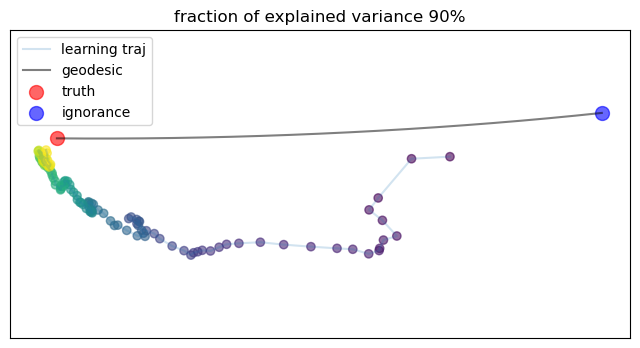

In [33]:
time_cutoff = 120
interval = 1
%matplotlib inline 
save_path = f"../figures/{file.stem}_Hellinger_2D.png"
fig = plt.figure(dpi = 100, figsize=(8,4))

dim1 = 0
dim2 = 1

plt.scatter(U_rescaled[:time_cutoff:interval,dim1], U_rescaled[:time_cutoff:interval,dim2], c=range(int(time_cutoff/interval)), alpha = 0.6)
plt.plot(U_rescaled[:time_cutoff:interval,dim1], U_rescaled[:time_cutoff:interval,dim2], alpha = 0.2, label ="learning traj")

plt.plot(U_rescaled[-geodesic_steps:,dim1], U_rescaled[-geodesic_steps:,dim2], alpha = 0.5, c='black', label ="geodesic")
plt.scatter(U_rescaled[-1,dim1], U_rescaled[-1,dim2], c='red', s = 100, label ="truth", alpha = 0.6)
plt.scatter(U_rescaled[-geodesic_steps,dim1], U_rescaled[-geodesic_steps,dim2], c='blue', s = 100, label ="ignorance", alpha = 0.6)

plt.xticks([])  # Turn off x-axis ticks
plt.yticks([])  # Turn off y-axis ticks
plt.title(f"fraction of explained variance {explained_var[1]/total_var*100:.0f}%")
plt.legend()
plt.axis('equal');
plt.savefig(save_path)



### Bhattacharyya Embedding

Text(0, 0.5, 'unexplained stress fraction')

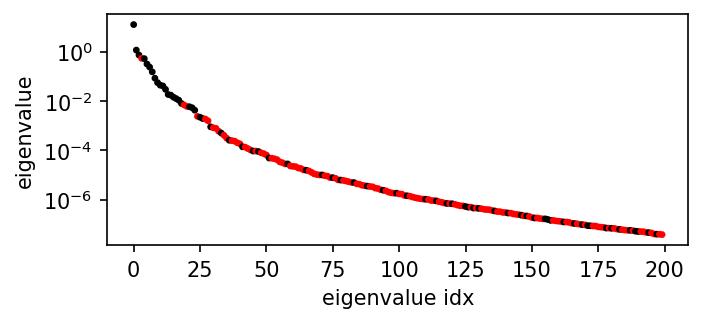

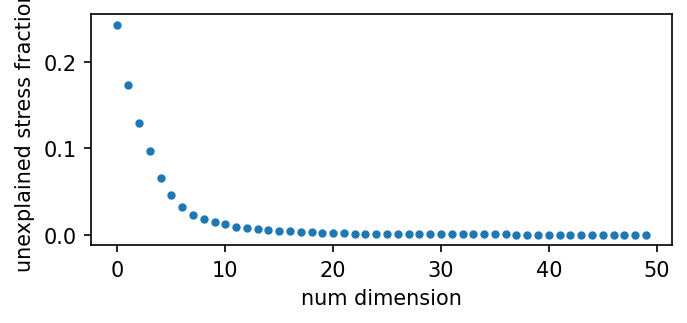

In [190]:
sigma, U = np.linalg.eigh(XXT_BT)
# Reorder sigma and U based on the absolute value of sigma in decreasing order
idx = np.argsort(np.abs(sigma))[::-1]
sigma = sigma[idx]
U = U[:, idx]

# U_rescaled = U * sigma
# Plot with color based on the sign of sigma
cutoff = 200
colors = ['black' if value > 0 else 'red' for value in sigma[:cutoff]]
plt.figure(figsize=(5,2), dpi=150)
plt.scatter(range(cutoff), np.abs(sigma[:cutoff]), c=colors, s = 5)
plt.xlabel('eigenvalue idx')
plt.ylabel('eigenvalue')
plt.yscale("log")

total_var = np.sum(np.abs(sigma))
explained_var = np.cumsum(np.abs(sigma))
plt.figure(figsize=(5,2), dpi=150)
plt.plot(1-explained_var[:50]/total_var, marker = '.', lw =0)
# plt.ylim(0,1.1)
# plt.yscale('log')
plt.xlabel('num dimension')
plt.ylabel('unexplained stress fraction')

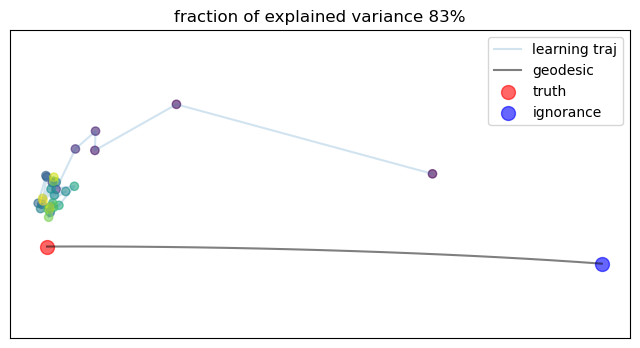

In [191]:
time_cutoff = 300
interval = 10
%matplotlib inline 
save_path = f"../figures/{file.stem}_BT_2D.png"
fig = plt.figure(dpi = 100, figsize=(8,4))

dim1 = 0
dim2 = 1

plt.scatter(U_rescaled[:time_cutoff:interval,dim1], U_rescaled[:time_cutoff:interval,dim2], c=range(int(time_cutoff/interval)), alpha = 0.6)
plt.plot(U_rescaled[:time_cutoff:interval,dim1], U_rescaled[:time_cutoff:interval,dim2], alpha = 0.2, label ="learning traj")

plt.plot(U_rescaled[-geodesic_steps:,dim1], U_rescaled[-geodesic_steps:,dim2], alpha = 0.5, c='black', label ="geodesic")
plt.scatter(U_rescaled[-1,dim1], U_rescaled[-1,dim2], c='red', s = 100, label ="truth", alpha = 0.6)
plt.scatter(U_rescaled[-geodesic_steps,dim1], U_rescaled[-geodesic_steps,dim2], c='blue', s = 100, label ="ignorance", alpha = 0.6)

plt.xticks([])  # Turn off x-axis ticks
plt.yticks([])  # Turn off y-axis ticks
plt.title(f"fraction of explained variance {explained_var[1]/total_var*100:.0f}%")
plt.legend()
plt.axis('equal');
plt.savefig(save_path)



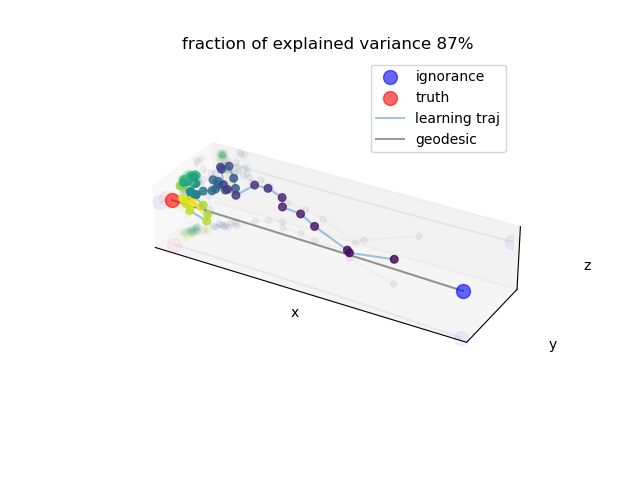

In [192]:
time_cutoff = 120
interval = 2

interactive = 1
shadows = 1
shadow_alpha = 0.05
if interactive:
    #interactive 3D plot
    %matplotlib widget 
    fig = plt.figure(dpi = 100)
else:    
# static 3D plot
    %matplotlib inline 
    fig = plt.figure(dpi = 100, figsize=(8,8))
    
save_path = f"../figures/{file.stem}_BT_3D.png"
ax = fig.add_subplot(111, projection='3d')

# invert x axis
# U_rescaled[:,0] = -U_rescaled[:,0]
ax.scatter3D(U_rescaled[:time_cutoff:interval,0], U_rescaled[:time_cutoff:interval,1], U_rescaled[:time_cutoff:interval,2], c=range(int(time_cutoff/interval)), s = 30, alpha = 0.8)
ax.scatter3D(U_rescaled[-geodesic_steps,0], U_rescaled[-geodesic_steps,1], U_rescaled[-geodesic_steps,2], c='blue', s = 100, label ="ignorance", alpha = 0.6)
ax.scatter3D(U_rescaled[-1,0], U_rescaled[-1,1], U_rescaled[-1,2], c='red', s = 100, label ="truth", alpha = 0.6)
ax.plot(U_rescaled[:time_cutoff:interval,0], U_rescaled[:time_cutoff:interval,1],U_rescaled[:time_cutoff:interval,2], alpha = 0.4, label ="learning traj")
ax.plot(U_rescaled[-geodesic_steps:,0], U_rescaled[-geodesic_steps:,1],U_rescaled[-geodesic_steps:,2], c='black', alpha = 0.4, label ="geodesic")
ax.legend()


x_min, x_max = U_rescaled[:,0].min(), U_rescaled[:,0].max()
y_min, y_max = U_rescaled[:,1].min(), U_rescaled[:,1].max()
z_min, z_max = U_rescaled[:,2].min(), U_rescaled[:,2].max()
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_zlim(z_min, z_max)

if shadows:
    # 2D projections
    for zdir, zs, idx_tuple in zip(['x','y','z'],[x_min, y_max, z_min],[(1,2),(0,2),(0,1)]):
        ax.plot(U_rescaled[:time_cutoff:interval,idx_tuple[0]], U_rescaled[:time_cutoff:interval,idx_tuple[1]], zdir=zdir, c = 'gray', alpha = shadow_alpha, zs=zs)
        ax.scatter(U_rescaled[:time_cutoff:interval,idx_tuple[0]], U_rescaled[:time_cutoff:interval,idx_tuple[1]], zdir=zdir, c = range(int(time_cutoff/interval)), alpha = shadow_alpha, zs=zs)
        
        ax.plot(U_rescaled[-geodesic_steps,idx_tuple[0]], U_rescaled[-geodesic_steps,idx_tuple[1]], zdir=zdir, c = 'blue', alpha = shadow_alpha, zs=zs, marker = 'o', markersize=10)
        ax.plot(U_rescaled[-1,idx_tuple[0]], U_rescaled[-1,idx_tuple[1]], zdir=zdir, c = 'red', alpha = shadow_alpha, zs=zs, marker = 'o', markersize=10)
        ax.plot(U_rescaled[-geodesic_steps:,idx_tuple[0]], U_rescaled[-geodesic_steps:,idx_tuple[1]], zdir=zdir, c = 'black', alpha = shadow_alpha, zs=zs)
        
    
ax.set_xticks([]) 
ax.set_yticks([]) 
ax.set_zticks([])

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.title(f"fraction of explained variance {explained_var[2]/total_var*100:.0f}%")
# plt.axis('equal')
ax.set_aspect('equal')
if not interactive:
    plt.savefig(save_path)
plt.show()